1. Initialization


In [2]:
import matplotlib.pyplot as plt
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import time
import pickle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, auc, RocCurveDisplay, roc_curve
import json
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
import seaborn as sns


folder = os.path.join("/", "Data", "CREMEv2_Result", "20230310", "logs_working", "toTrain")
train_technique = ["label_accounting_train_technique.csv",
               "relabel_syslog_train_technique.csv",
               "label_traffic_train_technique.csv"]
train_lifecycle = ["label_accounting_train_lifecycle.csv", 
               "relabel_syslog_train_lifecycle.csv",
               "label_traffic_train_lifecycle.csv"]
datas = ["accounting", "syslog", "traffic"]


for data in train_technique:
    if os.path.exists(os.path.join(folder, data)):
        print("Path is exists: ", data)
    else:
        print("Path is not exists: ", data)
        
for data in train_lifecycle:
    if os.path.exists(os.path.join(folder, data)):
        print("Path is exists: ", data)
    else:
        print("Path is not exists: ", data)

Path is exists:  label_accounting_train_technique.csv
Path is exists:  relabel_syslog_train_technique.csv
Path is exists:  label_traffic_train_technique.csv
Path is exists:  label_accounting_train_lifecycle.csv
Path is exists:  relabel_syslog_train_lifecycle.csv
Path is exists:  label_traffic_train_lifecycle.csv


2. Model Definition and Parameters Settings

In [3]:
r_state = 42
core = -1
model = XGBClassifier(objective='multi:softprob', eval_metric='merror', n_jobs=core)

evaluation_data = {}

model_name = list()
for data in train_technique:
    remove_extension = data.split('.')
    name = remove_extension[0].split('_')
    model_filename = 'model_xgboost_{}_{}'.format(name[1], name[-1])
    model_name += [model_filename]

for data in train_lifecycle:
    remove_extension = data.split('.')
    name = remove_extension[0].split('_')
    model_filename = 'model_xgboost_{}_{}'.format(name[1], name[-1])
    model_name += [model_filename]

print(model_name)


['model_xgboost_accounting_technique', 'model_xgboost_syslog_technique', 'model_xgboost_traffic_technique', 'model_xgboost_accounting_lifecycle', 'model_xgboost_syslog_lifecycle', 'model_xgboost_traffic_lifecycle']


3. Training and testing (Technique)

In [4]:
for i, data in enumerate(train_technique):
    print("Processing dataset: ", data)
    start_time = time.time()
    df = pd.read_csv(os.path.join(folder, data))
    model_folder = "model_auroc_combined"

    label_origin = sorted([int(i) for i in df['Label'].unique()])
    le = preprocessing.LabelEncoder()
    le.fit(df['Label'])
    le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

    X = df.drop(columns=['Label'])
    X = X.to_numpy()
    # X = X.reshape(-1)
    y = df['Label']
    y = y.to_numpy()
    y = y.reshape(-1)
    y = le.transform(y)
    
    class_label = list(label_origin)



    # print("Train Test Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r_state)

    # print("Data balancing")
    X_train, y_train = SMOTE(n_jobs=-1, random_state=r_state).fit_resample(X_train, y_train)
    
    if os.path.exists(os.path.join(model_folder, model_name[i])):
        print("Load ", model_name[i])
        model = pickle.load(open(os.path.join(model_folder, model_name[i]), 'rb'))
    else:
        model.fit(X_train, y_train)
        print("Dump ", model_name[i])
        pickle.dump(model, open(os.path.join(model_folder, model_name[i]), 'wb'))
    y_score = model.predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    evaluation_data[model_name[i]] = list((y_test, y_onehot_test, y_score))
    end_time = time.time()
    
    print("Execution Time: {:.2f}\n".format(end_time - start_time))

Processing dataset:  label_accounting_train_technique.csv


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Load  model_xgboost_accounting_technique
[13:50:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Execution Time: 8.95

Processing dataset:  relabel_syslog_train_technique.csv


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Load  model_xgboost_syslog_technique
[13:50:47] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Execution Time: 13.26

Processing dataset:  label_traffic_train_technique.csv


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Load  model_xgboost_traffic_technique
[13:51:00] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Execution Time: 12.24



4. Training and testing (Lifecycle)

In [6]:
for i, data in enumerate(train_lifecycle):
    print("Processing dataset: ", data)
    start_time = time.time()
    df = pd.read_csv(os.path.join(folder, data))
    model_folder = "model_auroc_combined"

    label_origin = sorted([int(i) for i in df['Label_lifecycle'].unique()])
    le = preprocessing.LabelEncoder()
    le.fit(df['Label_lifecycle'])
    le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

    X = df.drop(columns=['Label_lifecycle'])
    X = X.to_numpy()
    # X = X.reshape(-1)
    y = df['Label_lifecycle']
    y = y.to_numpy()
    y = y.reshape(-1)
    y = le.transform(y)
    
    class_label = list(label_origin)



    # print("Train Test Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=r_state)

    # print("Data balancing")
    X_train, y_train = SMOTE(n_jobs=-1, random_state=r_state).fit_resample(X_train, y_train)
    
    if os.path.exists(os.path.join(model_folder, model_name[i+3])):
        print("Load ", model_name[i+3])
        model = pickle.load(open(os.path.join(model_folder, model_name[i+3]), 'rb'))
    else:
        model.fit(X_train, y_train)
        print("Dump ", model_name[i+3])
        pickle.dump(model, open(os.path.join(model_folder, model_name[i+3]), 'wb'))
    y_score = model.predict_proba(X_test)
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    
    evaluation_data[model_name[i+3]] = list((y_test, y_onehot_test, y_score))
    end_time = time.time()
    
    print("Execution Time: {:.2f}\n".format(end_time - start_time))

Processing dataset:  label_accounting_train_lifecycle.csv


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Load  model_xgboost_accounting_lifecycle
[13:56:29] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Execution Time: 14.54

Processing dataset:  relabel_syslog_train_lifecycle.csv


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Load  model_xgboost_syslog_lifecycle
[13:56:34] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Execution Time: 4.80

Processing dataset:  label_traffic_train_lifecycle.csv


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Load  model_xgboost_traffic_lifecycle
[13:58:24] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

Execution Time: 111.46



In [7]:
for key, value in evaluation_data.items():
    print(key)
    

model_xgboost_accounting_technique
model_xgboost_syslog_technique
model_xgboost_traffic_technique
model_xgboost_accounting_lifecycle
model_xgboost_syslog_lifecycle
model_xgboost_traffic_lifecycle


5. Calculate AUROC micro average

In [8]:
roc_data_micro = dict()

for data in model_name:
    # stores all informations
    tpr, fpr, roc_auc = dict(), dict(), dict()
    fpr['micro'],  tpr['micro'], _ = roc_curve(evaluation_data[data][1].ravel(), evaluation_data[data][2].ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
    roc_data_micro[data] = list((fpr['micro'], tpr['micro'], roc_auc['micro']))

    print("Micro average : {:.2f}".format(roc_auc['micro']))


Micro average : 1.00
Micro average : 0.76
Micro average : 1.00
Micro average : 0.86
Micro average : 0.63
Micro average : 1.00


6. Calculate AUROC macro average

In [9]:
roc_data_macro = dict()

for data in model_name:
    for i in range(len(class_label)):
        fpr[i], tpr[i], _ = roc_curve(evaluation_data[data][1][:, i], evaluation_data[data][2][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fpr_grid = np.linspace(0.0, 1.0, 1000)
    
    mean_tpr = np.zeros_like(fpr_grid)
    
    for i in range(len(class_label)):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])
    
    mean_tpr /= len(class_label)
    
    fpr['macro'] = fpr_grid
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    roc_data_macro[data] = list((fpr['macro'], tpr['macro'], roc_auc['macro']))
    
    

    print("Macro average of  : {:.2f}".format(roc_auc['macro']))

Macro average of  : 1.00
Macro average of  : 0.69
Macro average of  : 1.00
Macro average of  : 0.83
Macro average of  : 0.61
Macro average of  : 1.00


7. Plot to diagram

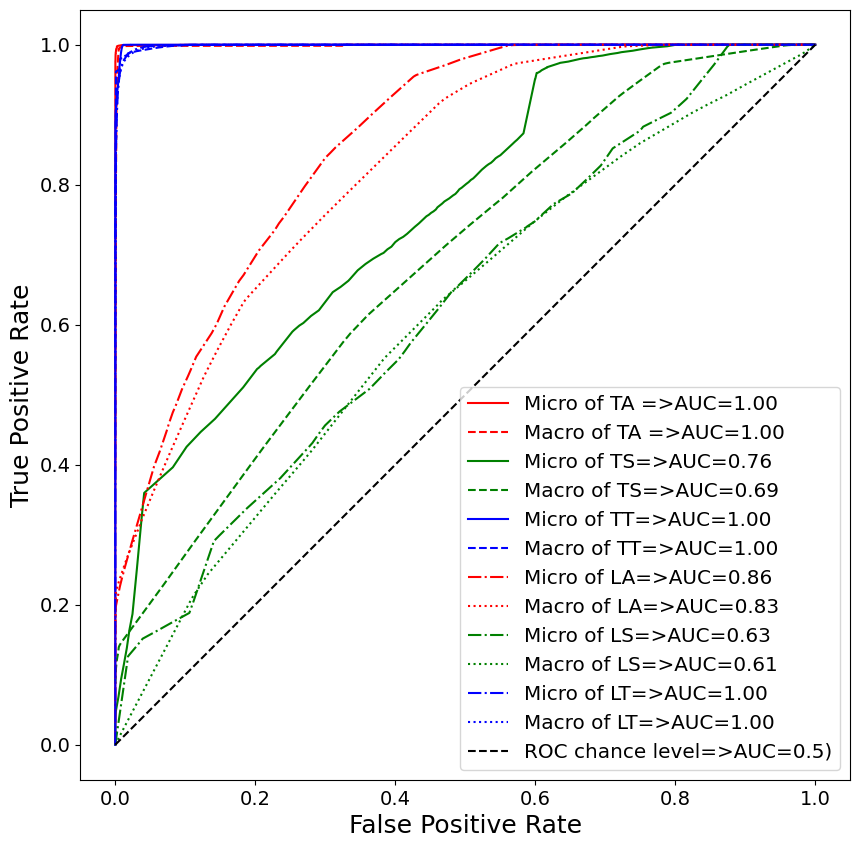

In [10]:


fig, ax = plt.subplots(figsize=(10, 10))
legend_data = ["TA ",
               "TS",
               "TT",
               "LA",
               "LS",
               "LT"
               ]


plt.plot(
    roc_data_micro['model_xgboost_accounting_technique'][0],
    roc_data_micro['model_xgboost_accounting_technique'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[0], roc_data_micro['model_xgboost_accounting_technique'][2]),
    color='red', 
    linestyle='solid'
)

plt.plot(
    roc_data_macro['model_xgboost_accounting_technique'][0],
    roc_data_macro['model_xgboost_accounting_technique'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[0], roc_data_macro['model_xgboost_accounting_technique'][2]),
    color='red',
    linestyle='dashed'
)

plt.plot(
    roc_data_micro['model_xgboost_syslog_technique'][0],
    roc_data_micro['model_xgboost_syslog_technique'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[1], roc_data_micro['model_xgboost_syslog_technique'][2]),
    color='green',
    linestyle='solid'
)

plt.plot(
    roc_data_macro['model_xgboost_syslog_technique'][0],
    roc_data_macro['model_xgboost_syslog_technique'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[1], roc_data_macro['model_xgboost_syslog_technique'][2]),
    color='green',
    linestyle='dashed'
)

plt.plot(
    roc_data_micro['model_xgboost_traffic_technique'][0],
    roc_data_micro['model_xgboost_traffic_technique'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[2], roc_data_micro['model_xgboost_traffic_technique'][2]),
    color='blue',
    linestyle='solid'
)

plt.plot(
    roc_data_macro['model_xgboost_traffic_technique'][0],
    roc_data_macro['model_xgboost_traffic_technique'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[2], roc_data_macro['model_xgboost_traffic_technique'][2]),
    color='blue',
    linestyle='dashed'
)

plt.plot(
    roc_data_micro['model_xgboost_accounting_lifecycle'][0],
    roc_data_micro['model_xgboost_accounting_lifecycle'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[3], roc_data_micro['model_xgboost_accounting_lifecycle'][2]),
    color='red',
    linestyle='dashdot'
)

plt.plot(
    roc_data_macro['model_xgboost_accounting_lifecycle'][0],
    roc_data_macro['model_xgboost_accounting_lifecycle'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[3], roc_data_macro['model_xgboost_accounting_lifecycle'][2]),
    color='red',
    linestyle='dotted'
)

plt.plot(
    roc_data_micro['model_xgboost_syslog_lifecycle'][0],
    roc_data_micro['model_xgboost_syslog_lifecycle'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[4], roc_data_micro['model_xgboost_syslog_lifecycle'][2]),
    color='green',
    linestyle='dashdot'
)

plt.plot(
    roc_data_macro['model_xgboost_syslog_lifecycle'][0],
    roc_data_macro['model_xgboost_syslog_lifecycle'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[4], roc_data_macro['model_xgboost_syslog_lifecycle'][2]),
    color='green',
    linestyle='dotted'
)

plt.plot(
    roc_data_micro['model_xgboost_traffic_lifecycle'][0],
    roc_data_micro['model_xgboost_traffic_lifecycle'][1],
    label="Micro of {}=>AUC={:.2f}".format(legend_data[5], roc_data_micro['model_xgboost_traffic_lifecycle'][2]),
    color='blue',
    linestyle='dashdot'
)

plt.plot(
    roc_data_macro['model_xgboost_traffic_lifecycle'][0],
    roc_data_macro['model_xgboost_traffic_lifecycle'][1],
    label="Macro of {}=>AUC={:.2f}".format(legend_data[5], roc_data_macro['model_xgboost_traffic_lifecycle'][2]),
    color='blue',
    linestyle='dotted'
)



plt.plot([0, 1], [0, 1], "k--", label="ROC chance level=>AUC=0.5)")
plt.axis("square")
plt.tick_params(axis='both', labelsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
# plt.title("ROC Curve of Micro and Macro Average for All Dataset in Technique")
plt.legend(fontsize='x-large')
plt.show()